In [1]:
#Imports
import numpy as np
from ChainConsumer import ChainConsumer
from load_hyperparams import *
from masks import load_survey_masks
from satellite_realization import satellite_realization, evaluate_ln_likelihood, evaluate_ln_prior, mcmc
from load_satellites import get_true_counts

In [2]:
#Load hyperparameters
hparams, prior_hparams, cosmo_params, orphan_params, halo_data, sim_indices, vpeak_Mr_interp = load_hyperparams()

#Set parameters
params = load_params()
default_param_vector = np.array(list(load_params().values()))

#For likelihood illustration
ruled_out_M50_param_vector = np.array(list(load_params().values()))
ruled_out_M50_param_vector[2] = 8.4

ruled_out_Mhm_param_vector = np.array(list(load_params().values()))
ruled_out_Mhm_param_vector[-1] = 8.0

In [3]:
#Load masks and ssfs
print('loading masks and ssfs ... \n')
masks,ssfs = load_survey_masks()
print('\n done')

loading masks and ssfs ... 

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
[13:33:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:764: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
[13:33:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:764: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/eon/Documents/subhalo_satellite_connection/1912.03303/ssf.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.config = yaml.load(open(config_file))
/Users/eon/Library/Python/3.7/lib/python/site-packages/xgboost/sklearn.py:418: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  'Loading a native XGBoost model with Scikit-Learn interface.')


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
[13:33:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:764: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
[13:33:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:764: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT

 done


In [4]:
#Get list of satellite realizations
combined_satellite_properties_list, mock_counts = satellite_realization(default_param_vector,
                                                           hparams,cosmo_params,orphan_params,
                                                           halo_data,sim_indices,
                                                           vpeak_Mr_interp,masks,ssfs,'cdm')

In [5]:
#First look at predictions
satellite_num = {}
satellite_num['des'] = []
satellite_num['ps1'] = []

for i in range(len(combined_satellite_properties_list)):
    for survey in ['des','ps1']:
        flags = combined_satellite_properties_list[i]['{}_flags'.format(survey)]
        satellite_num[survey].append(np.sum(combined_satellite_properties_list[i]['pdet'][flags]))

for survey in ['des','ps1']:
    print('number of predicted {} satellites = {:.1f} +/- {:.1f}'.format(survey,np.mean(satellite_num[survey],axis=0),
                                                                         np.std(satellite_num[survey],axis=0)))

number of predicted des satellites = 14.8 +/- 3.5
number of predicted ps1 satellites = 20.7 +/- 3.4


In [6]:
#Illustrate likelihood evaluation
true_counts = get_true_counts()

#For default parameters
lnlike = evaluate_ln_likelihood(default_param_vector,hparams,cosmo_params,orphan_params,
                                halo_data,sim_indices,vpeak_Mr_interp,
                                masks,ssfs,true_counts,suppression='cdm',surveys=['des','ps1'])

#For suppressed galaxy formation
lnlike_suppressed = evaluate_ln_likelihood(ruled_out_M50_param_vector,hparams,cosmo_params,orphan_params,
                                halo_data,sim_indices,vpeak_Mr_interp,
                                masks,ssfs,true_counts,suppression='cdm',surveys=['des','ps1'])

print('M50 log-likelihood ratio = {}'.format(lnlike_suppressed-lnlike))

#For warm dark matter suppression
lnlike_suppressed = evaluate_ln_likelihood(ruled_out_Mhm_param_vector,hparams,cosmo_params,orphan_params,
                                halo_data,sim_indices,vpeak_Mr_interp,
                                masks,ssfs,true_counts,suppression='wdm',surveys=['des','ps1'])

print('Mhm log-likelihood ratio = {}'.format(lnlike_suppressed-lnlike))

/Users/eon/Library/Python/3.7/lib/python/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


M50 log-likelihood ratio = -7.116507617757307
Mhm log-likelihood ratio = -3.810064170371632


In [7]:
#Short run to demonstrate functionality; not converged!
samples = mcmc(default_param_vector,hparams,prior_hparams,cosmo_params,orphan_params,
                                halo_data,sim_indices,vpeak_Mr_interp,
                                masks,ssfs,true_counts,suppression='wdm',surveys=['des','ps1'])

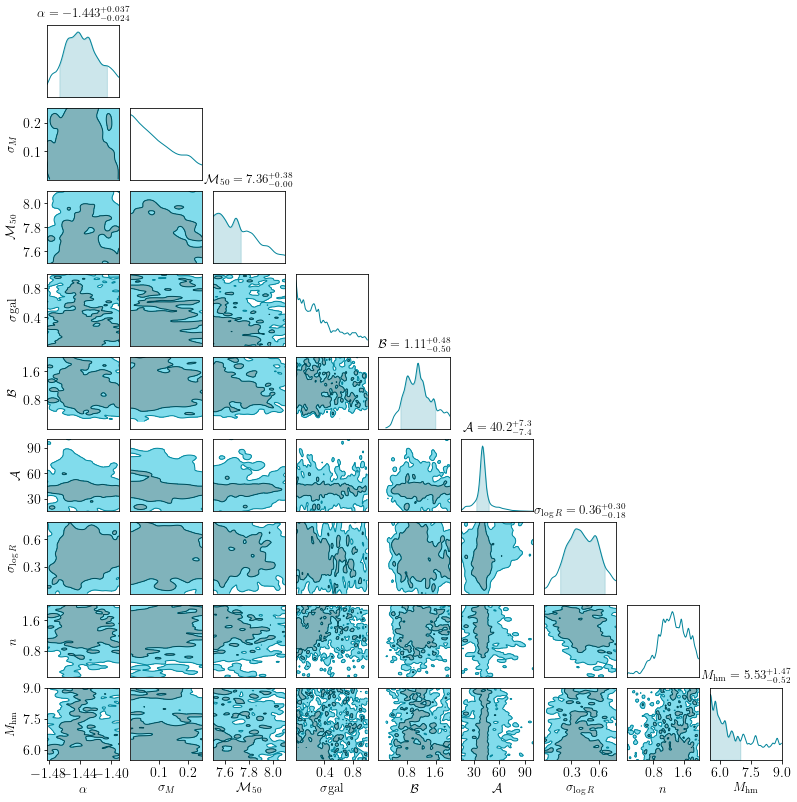

In [8]:
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\alpha$",r"$\sigma_M$",r"$\mathcal{M}_{50}$",r"$\sigma{\mathrm{gal}}$",
                                 r"$\mathcal{B}$",r"$\mathcal{A}$",r"$\sigma_{\log R}$",r"$n$",r"$M_{\mathrm{hm}}$"])

c.configure(colors=["#04859B", "#003660"], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=3.0,
            diagonal_tick_labels=False, tick_font_size=14, label_font_size=13, sigma2d=False,max_ticks=3, 
            summary=True,kde=False)

fig = c.plotter.plot(figsize=(12,12),extents=[[-1.482,-1.39],[0,0.25],[7.5,8.1],[0,1],[0,2],[15,100],[0,0.785],
                                              [0.1,2],[5.5,9]],display=True,filename="corner_Mhm.pdf")